In [16]:
from transformers import pipeline
import torch
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

# Define the model checkpoint
model_name = "FacebookAI/roberta-large-mnli"

print("Loading model... this may take a minute.")

# 1. Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 2. Load Model
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 3. Verify Label Mapping (Crucial Step)
# We expect: 0 -> Contradiction (NTA), 2 -> Entailment (YTA)
print(f"Model Label Map: {model.config.id2label}")


Loading model... this may take a minute.


Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Label Map: {0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}


In [2]:
data = pd.read_csv("data/samples/balanced_sample_200.csv")

X_train, X_test, y_train, y_test = train_test_split(
    data[["selftext"]],
    data["target"],
    test_size=0.2,
    random_state=42,
    stratify=data["target"]
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

X_train.shape, X_val.shape, X_test.shape

((122, 1), (31, 1), (39, 1))

# Modelling

In [ ]:
def predict_verdict_forced(post):
    hypothesis = "The author of this story is being an asshole."
    
    # 1. Encode
    input_ids = tokenizer.encode(
        post, 
        hypothesis, 
        return_tensors="pt",
        truncation=True,
        max_length=512
    )
    
    # 2. Get Logits
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits[0]  # Shape: [3] -> [Contradiction, Neutral, Entailment]

    # --- THE HEAVY LIFTING FIX ---
    # RoBERTa MNLI mapping: 0=Contradiction (NTA), 1=Neutral, 2=Entailment (YTA)
    
    # We slice out only indices 0 and 2
    binary_logits = torch.tensor([logits[0], logits[2]]) 
    
    # We re-calculate softmax on just these two options
    probs = F.softmax(binary_logits, dim=0)
    
    nta_prob = probs[0].item() # Contradiction
    yta_prob = probs[1].item() # Entailment (now index 1 of our binary tensor)

    # 3. Simple Decision
    if yta_prob > nta_prob:
        print(1)
        return 1 # YTA
    else:
        print(0)
        return 0 # NTA

# --- Run your loop again with this function ---

data['prediction'] = data['selftext'].apply(predict_verdict_forced)

0
1
0
0
1
0
1
0
1
0
0
0
0
1
0
1
0
0
1
0
0
1
1
1
0
0
0
1
0
0
1


              precision    recall  f1-score   support

           0       0.58      0.73      0.65        15
           1       0.67      0.50      0.57        16

    accuracy                           0.61        31
   macro avg       0.62      0.62      0.61        31
weighted avg       0.62      0.61      0.61        31



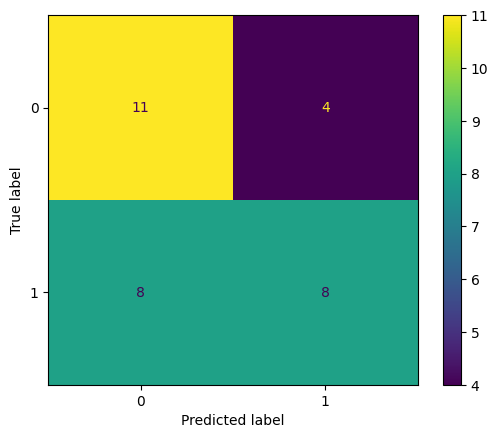

In [ ]:
print(classification_report(y_val, X_val["prediction"], zero_division=0))
cm = confusion_matrix(y_val, X_val["prediction"])
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()